In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
df = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)  ## read all data from 2013 to 2016
df.index.freq = "D"
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197
std,7.339416,16.743928,4.559688,180.293335
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.571429
50%,27.714286,62.625000,6.250000,1008.555556
75%,31.312500,72.125000,9.250000,1014.937500
max,38.714286,98.000000,42.220000,7679.333333


In [5]:
attributs = df.columns.values
names = ['Mean Temperature','Humidity', 'Wind Speed', 'Mean Pressure']
attributs

array(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype=object)

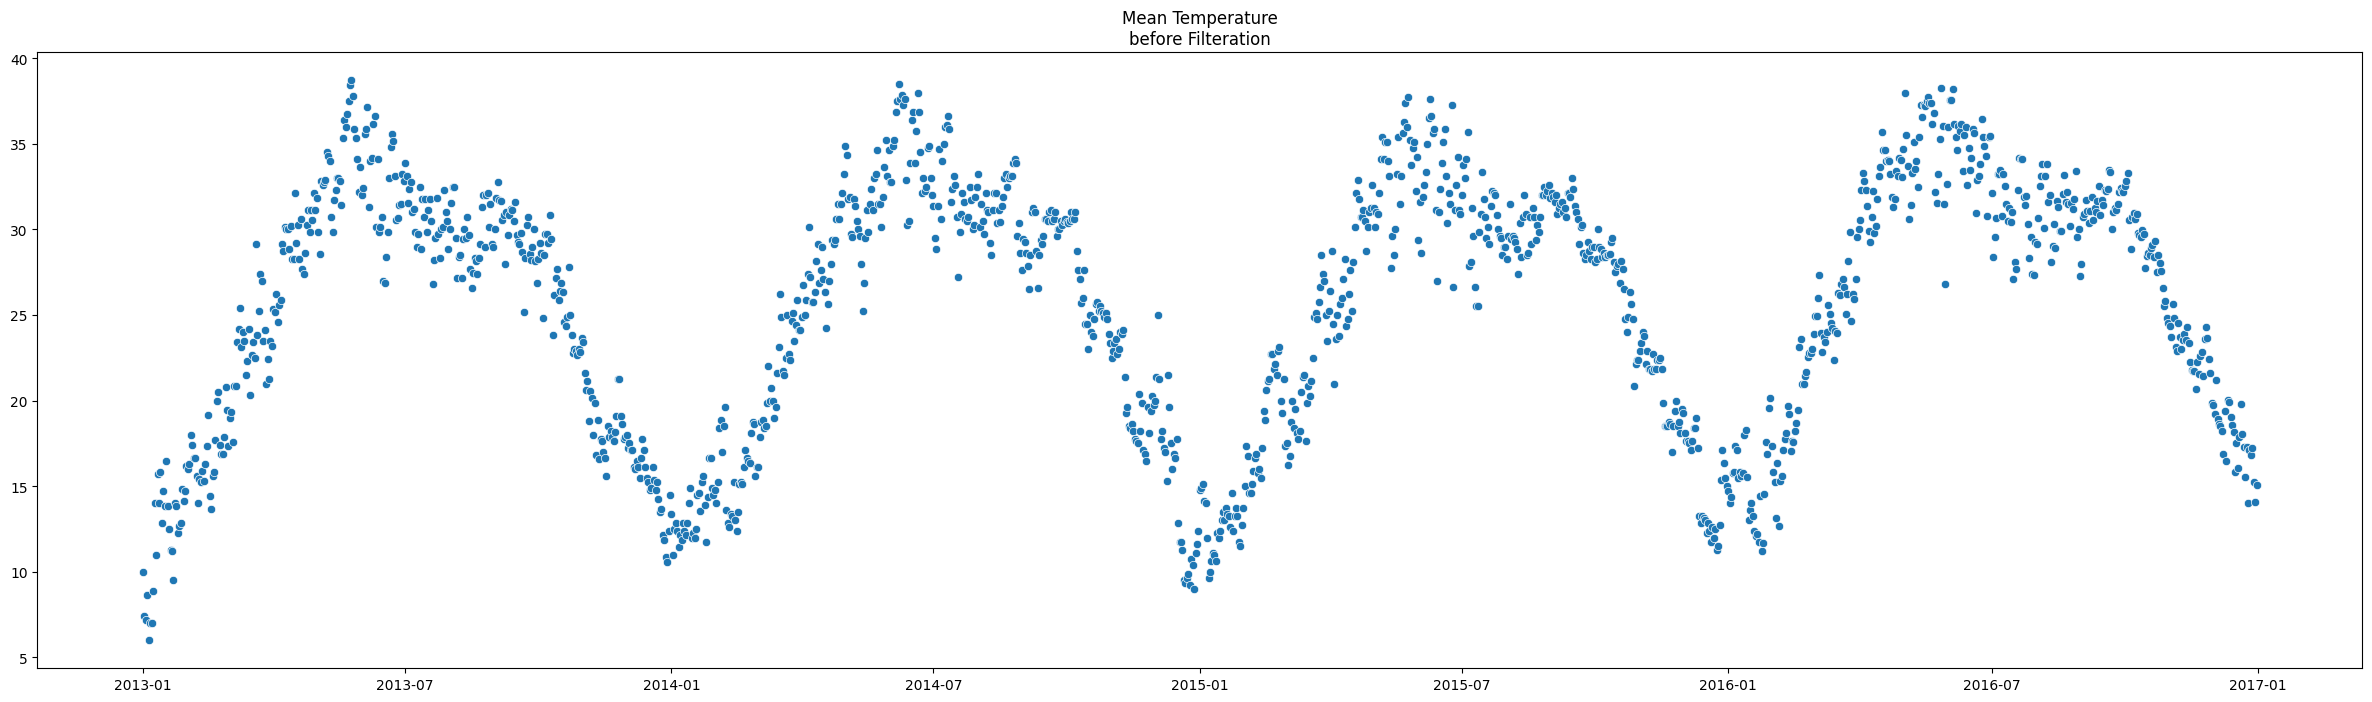

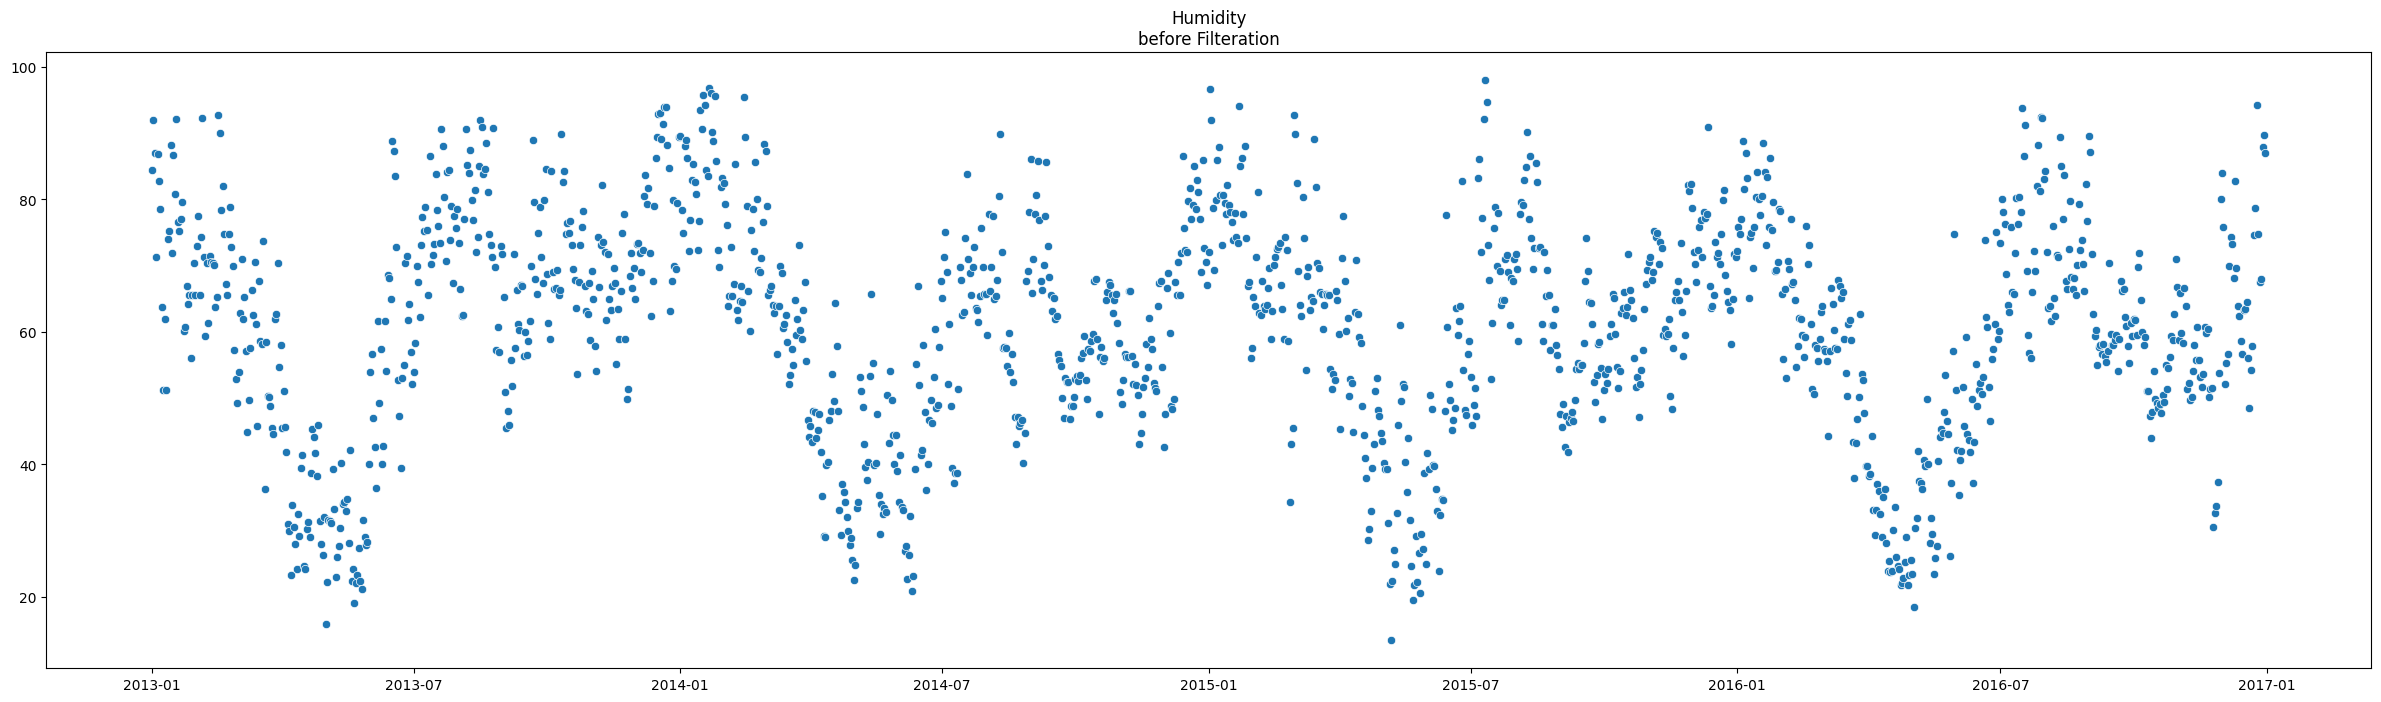

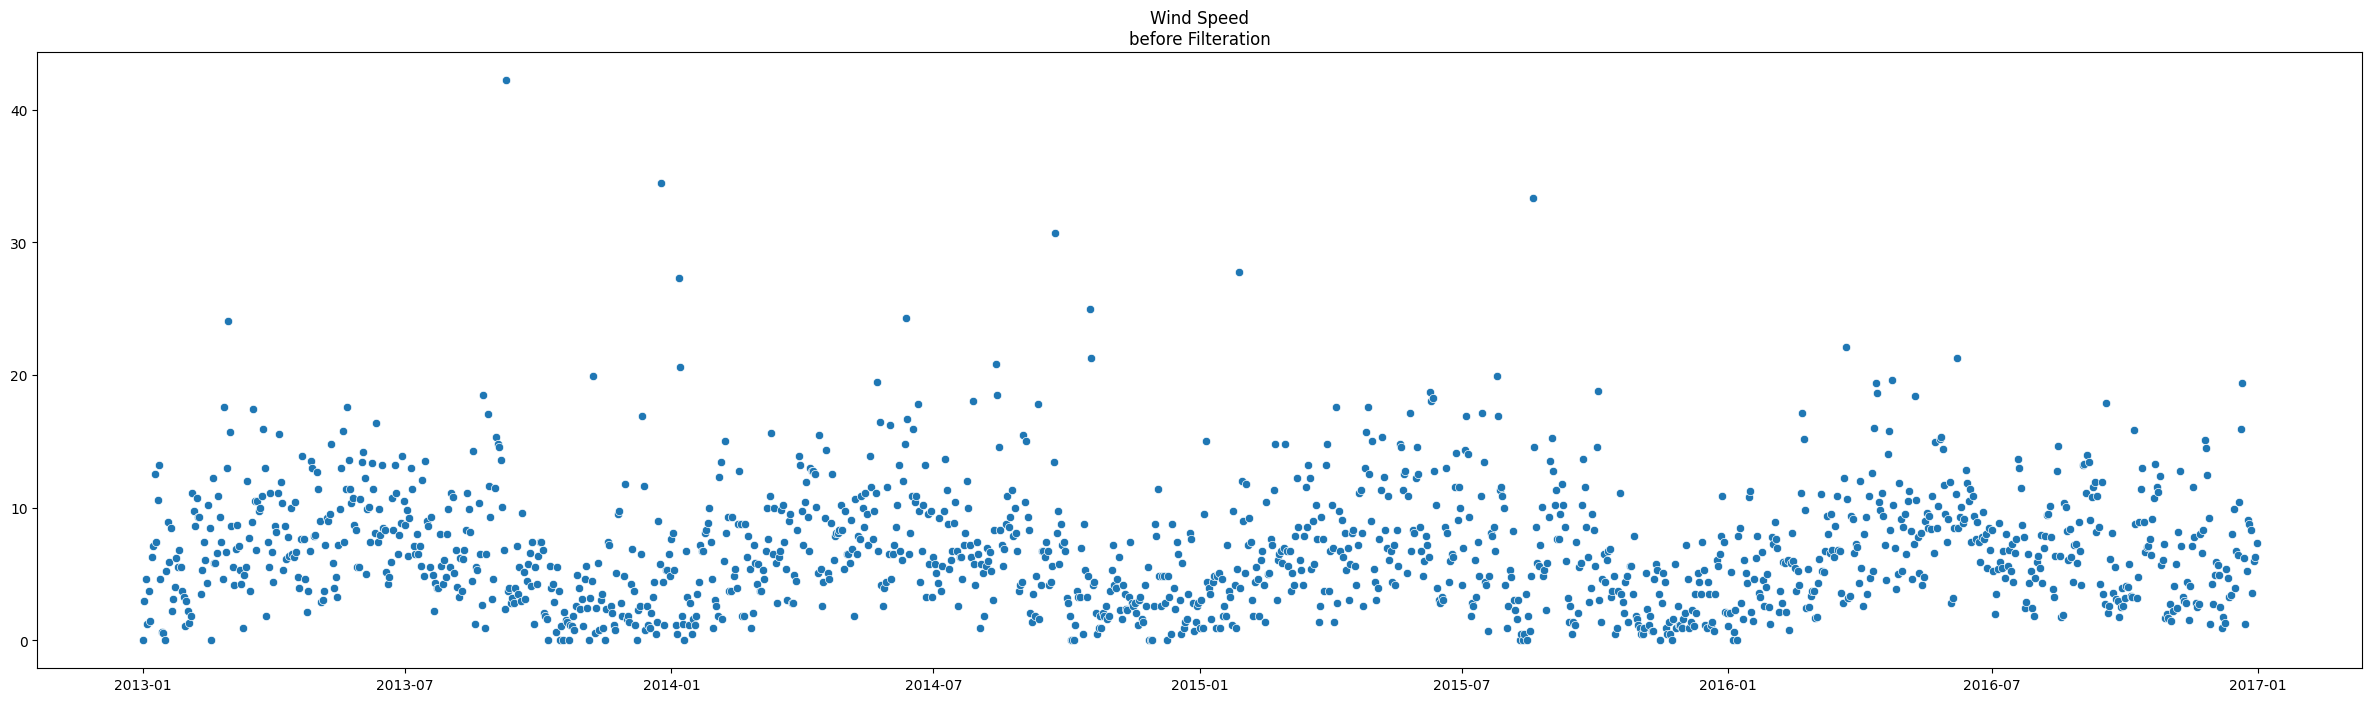

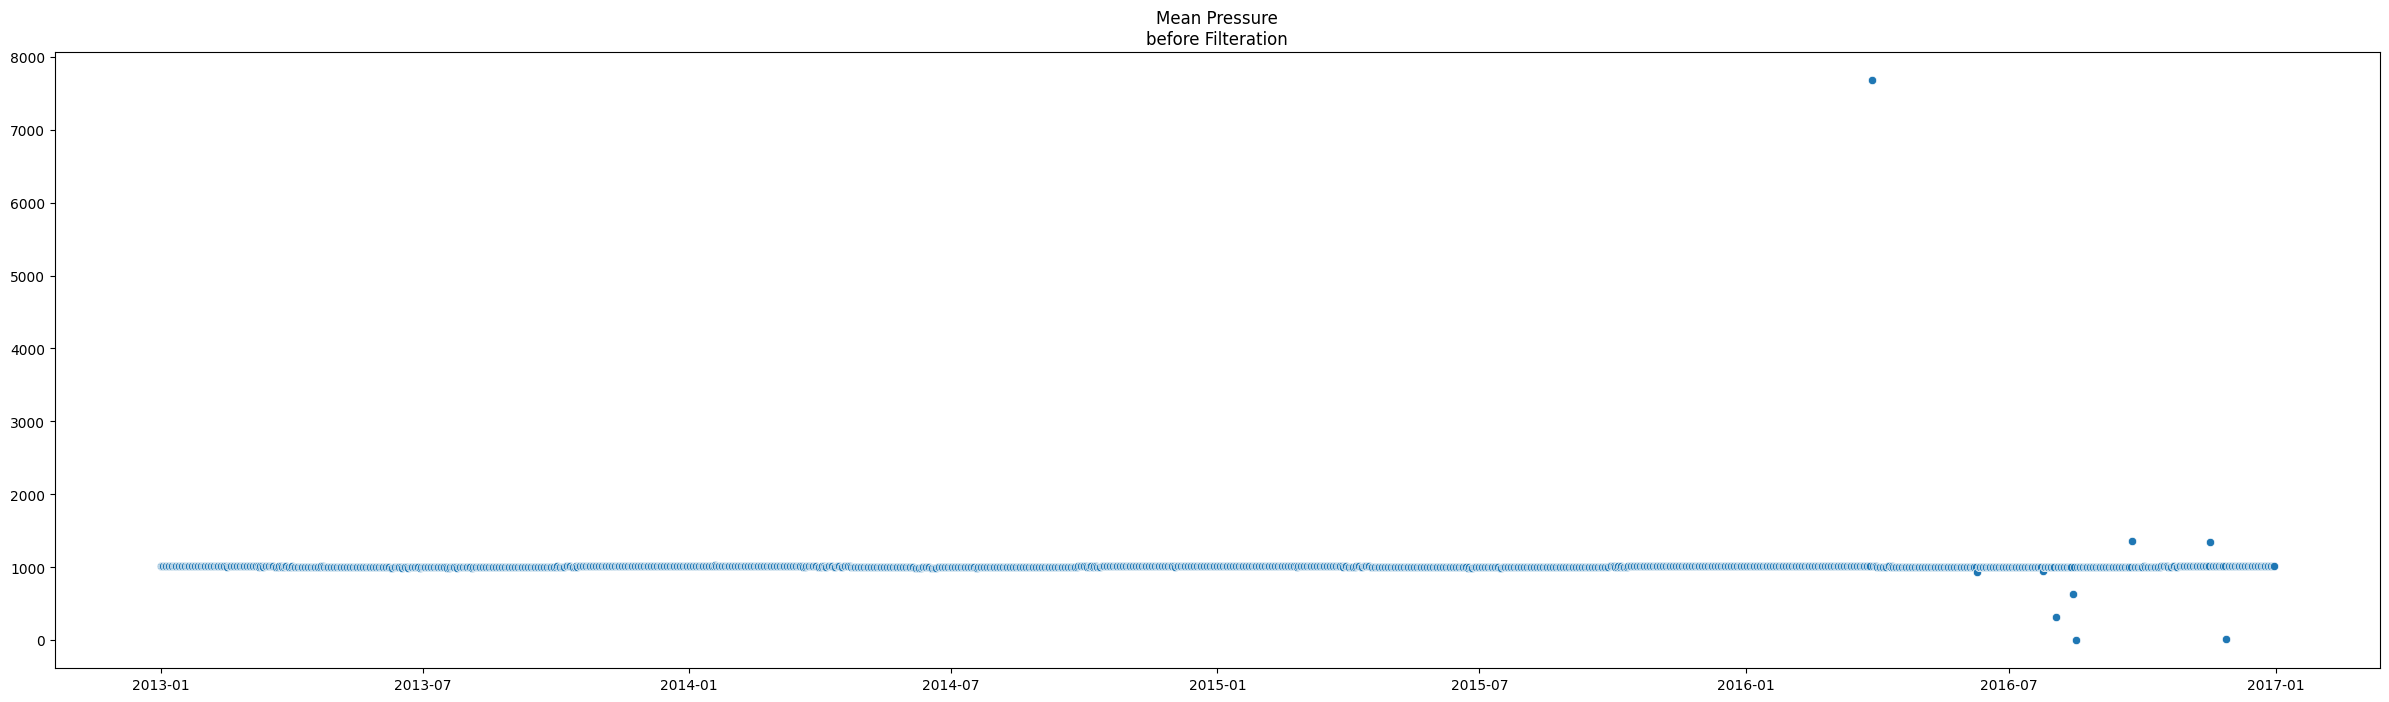

In [6]:
def showAllTimeSeries(df,filter):
    for atr,name in zip(attributs, names):
        plt.figure(figsize=(30,8))
        sb.scatterplot(x= df.index, y = df[atr])
        plt.title(name + '\nbefore Filteration') if filter else plt.title(name + '\nafter Filteration')
        plt.ylabel('')
        plt.xlabel('')
        plt.show()
        
showAllTimeSeries(df,1)

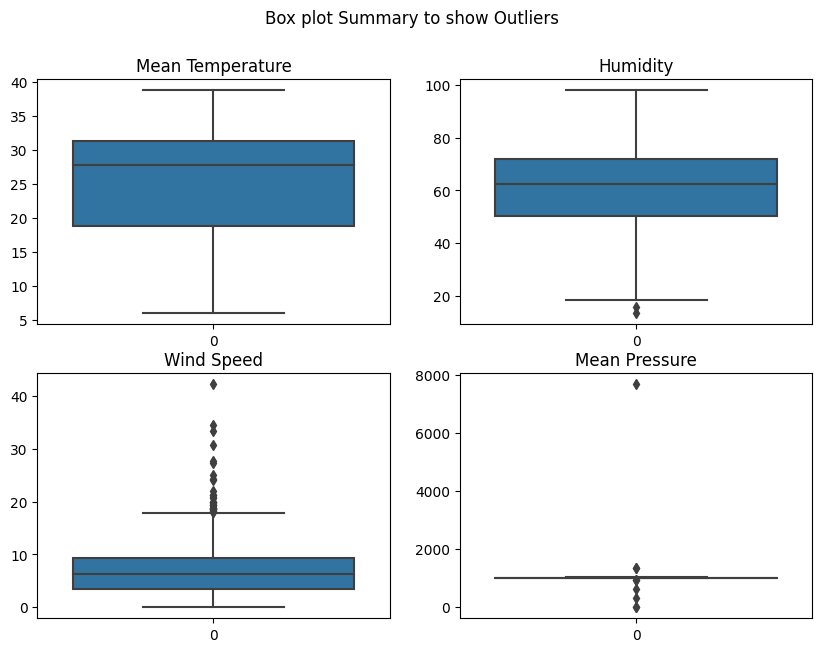

In [7]:
def showALlBoxPlot(df, msg):
    fig, axs = plt.subplots(2,2, figsize=(10,7))
    fig.suptitle(msg)
    fig.subplots_adjust(wspace=.2, hspace=.2)

    idx = 0
    for atr, ax in zip(attributs, axs.ravel()):
        sb.boxplot(data = df[atr], ax=ax)
        ax.set_title(names[idx])
        idx+=1

    

showALlBoxPlot(df, "Box plot Summary to show Outliers")


In [8]:
for atr in attributs:
    q1 = np.quantile(df[atr], .25)  # fisrt quantile 
    q3 = np.quantile(df[atr], .75)  # third quantile
    
    iqr = np.abs(q3-q1)             # inter qurtile range
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr

    df = df[(df[atr] >= lower_bound) & (df[atr] <= upper_bound)]


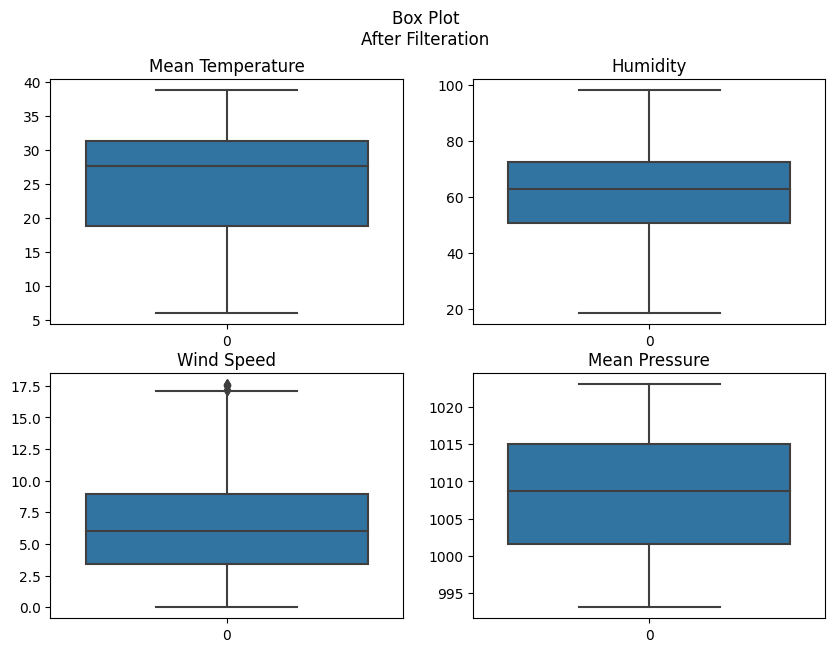

In [9]:
showALlBoxPlot(df, "Box Plot\nAfter Filteration",)

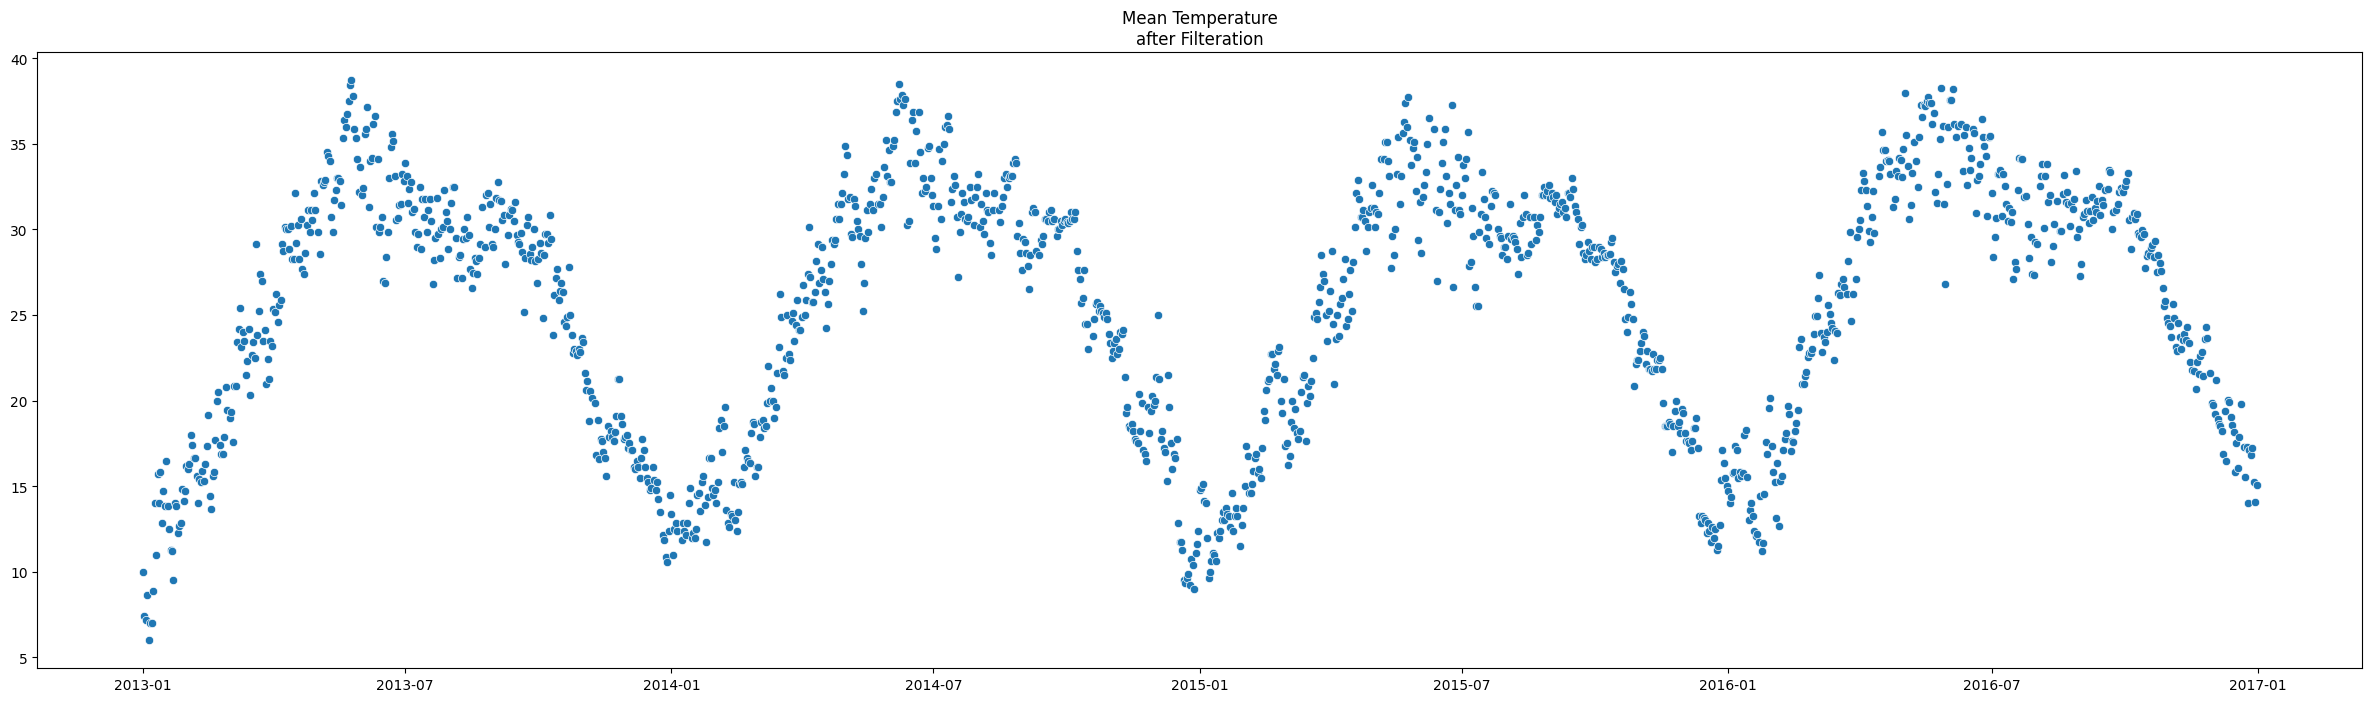

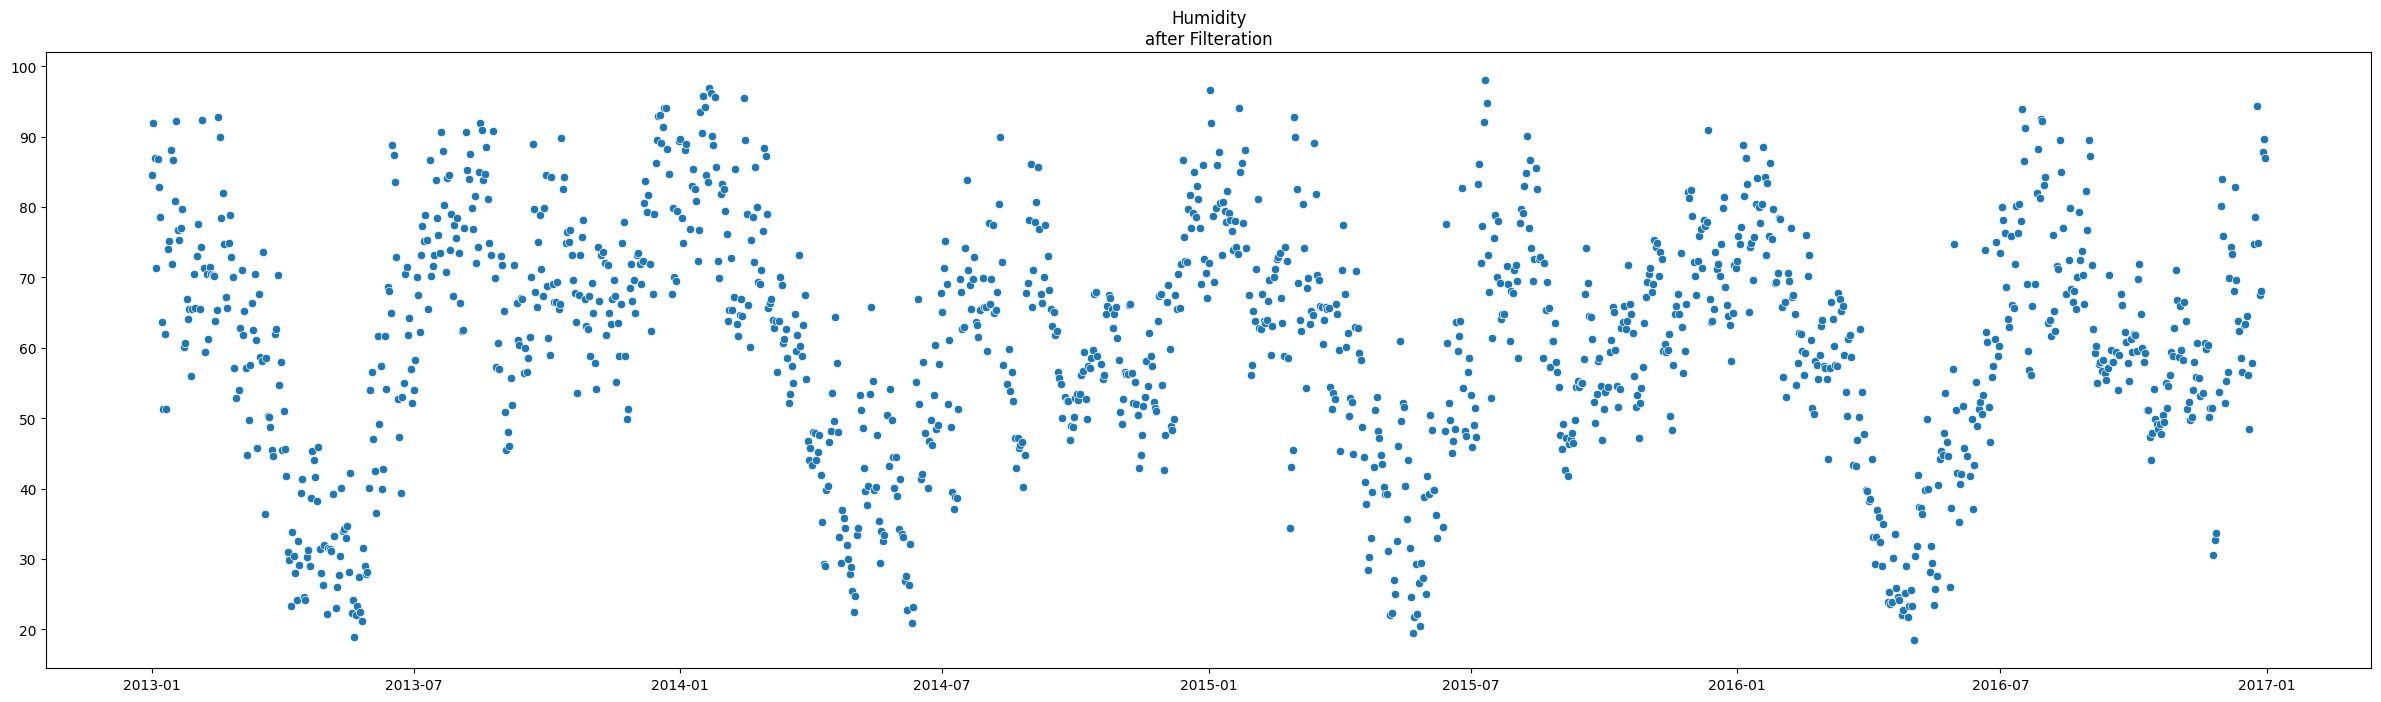

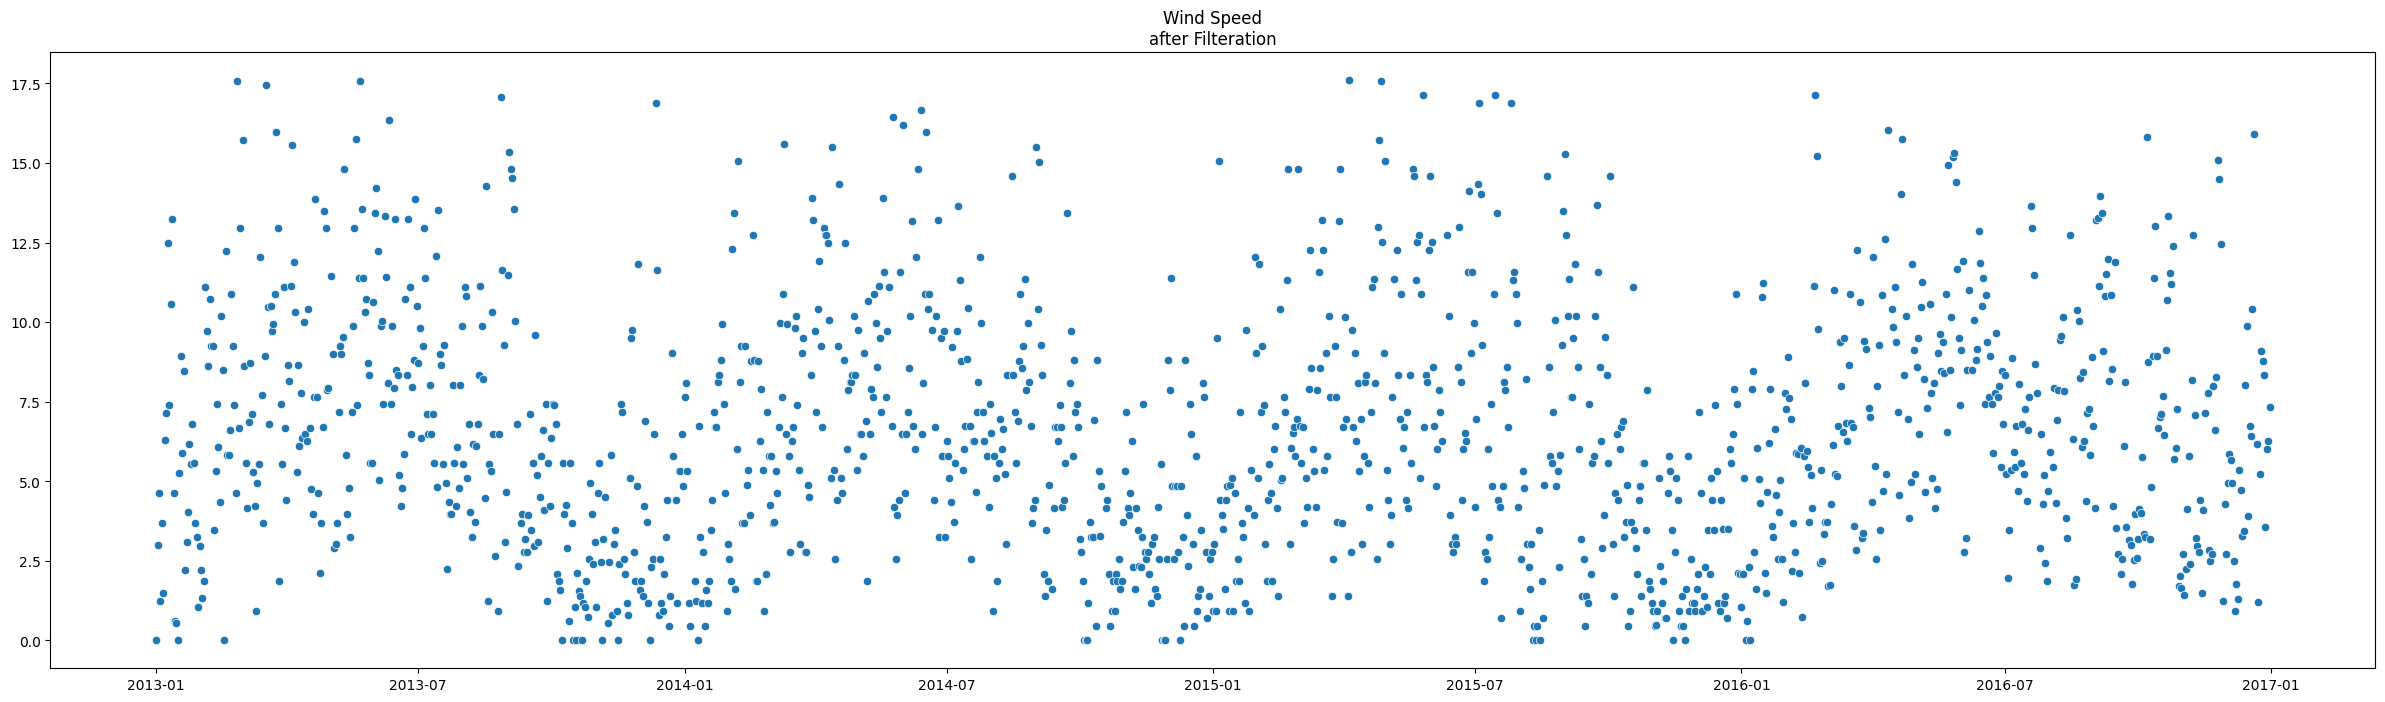

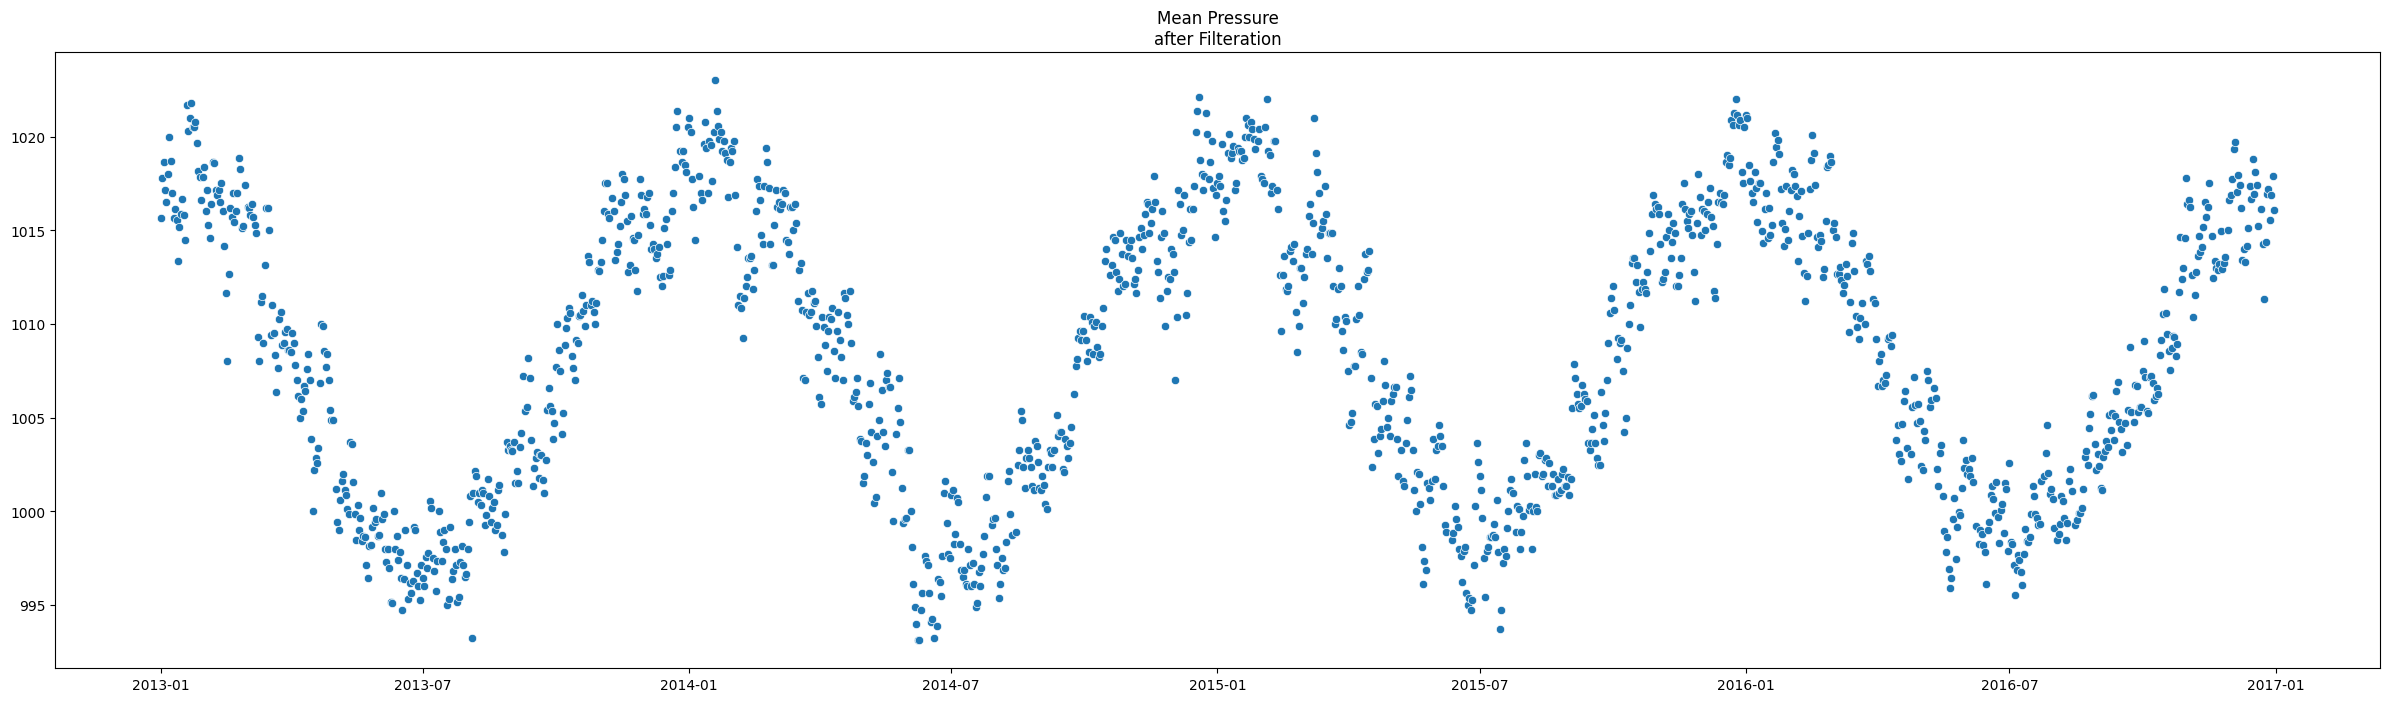

In [10]:
showAllTimeSeries(df,0)

In [11]:
print("Summary of the Weather: ")
for i in range(len(names)):
    print('# '+names[i])
    maxData = df[df[attributs[i]] == df[attributs[i]].max()]
    print(f'  + The Maximum {names[i]} is {maxData[attributs[i]].values[0]:<7.2f} \
in Year {maxData.index[0].year} Month {maxData.index[0].month}')

    minData=  df[df[attributs[i]] == df[attributs[i]].min()]
    print(f'  + The Minimum {names[i]} is {minData[attributs[i]].values[0]:<7.2f}\
 in Year {minData.index[0].year} month {minData.index[0].month}')


Summary of the Weather: 
# Mean Temperature
  + The Maximum Mean Temperature is 38.71   in Year 2013 Month 5
  + The Minimum Mean Temperature is 6.00    in Year 2013 month 1
# Humidity
  + The Maximum Humidity is 98.00   in Year 2015 Month 7
  + The Minimum Humidity is 18.47   in Year 2016 month 5
# Wind Speed
  + The Maximum Wind Speed is 17.60   in Year 2015 Month 4
  + The Minimum Wind Speed is 0.00    in Year 2013 month 1
# Mean Pressure
  + The Maximum Mean Pressure is 1023.00 in Year 2014 Month 1
  + The Minimum Mean Pressure is 993.12  in Year 2014 month 6


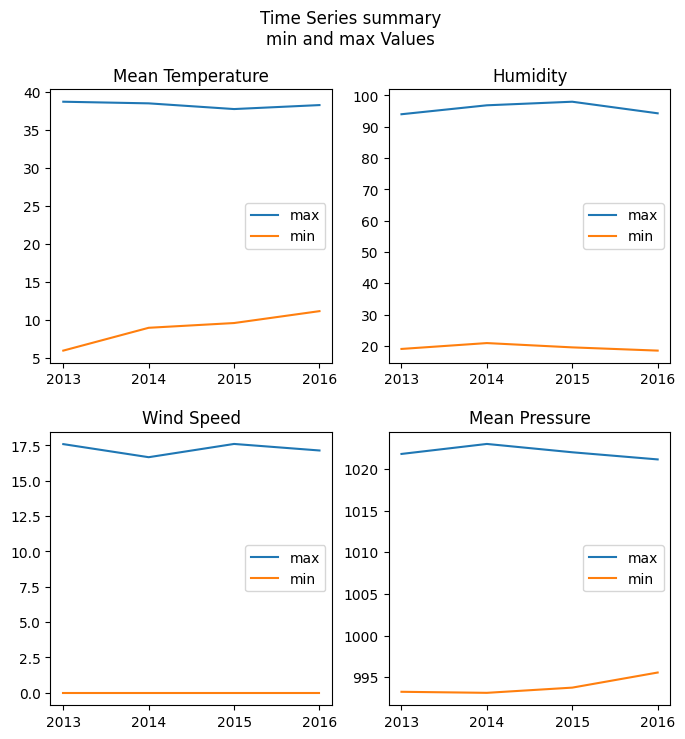

In [12]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
fig.suptitle("Time Series summary\nmin and max Values")
fig.subplots_adjust(wspace=.2, hspace=.25)

idx = 0
for atr, ax in zip(attributs, axs.ravel()):
    ndf = df.groupby(df.index.year)[atr].describe()[['max', 'min']].plot(ax=ax)
    ax.set_title(names[idx])
    ax.set_xlabel("")
    idx+=1

plt.show()
    

Forcasting Model

In [13]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

array([2.08676622e-01, 6.46134141e-02, 9.91888150e-03, 2.67248917e-09])

In [19]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #creating the train and validation set
    train = df[:int(0.8*(len(df)))]
    valid = df[int(0.8*(len(df))):]

    #fit the model
    from statsmodels.tsa.vector_ar.var_model import VAR

    model = VAR(endog=train)
    model_fit = model.fit()
    # make prediction on validation
    prediction = model_fit.forecast(model_fit.endog, steps=len(valid))
    print(prediction)

[[  23.69894869   57.87884785    8.18013027 1012.23774951]
 [  23.55190457   58.47289083    6.9686177  1011.92174966]
 [  23.45236892   58.97866667    6.44862704 1011.67232656]
 ...
 [  24.95895049   61.58231482    6.32822896 1008.35456646]
 [  24.95921145   61.58213493    6.32827568 1008.35428589]
 [  24.95946776   61.58195824    6.32832157 1008.35401032]]


In [15]:
from sklearn import metrics

In [16]:
cols = df.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,4):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(metrics.mean_squared_error(pred[i], valid[i])))

rmse value for meantemp is :  7.343917358667135
rmse value for humidity is :  17.53257915874473
rmse value for wind_speed is :  3.6296718200834386
rmse value for meanpressure is :  6.700137381545931


In [17]:
#make final predictions
from datetime import timedelta
the_last_day = df.index[-1]
steps = int(input("enter steps to forcast(int): "))
yhat = model_fit.forecast(model_fit.endog, steps=steps)

indexs = [the_last_day + timedelta(i+1) for i in range(steps)]
predDf = pd.DataFrame(columns=cols, index=[indexs])

for step in range(steps):
    predDf.loc[indexs[step]] = yhat[step]

predDf

,meantemp,humidity,wind_speed,meanpressure
2017-01-01,23.698949,57.878848,8.18013,1012.23775
2017-01-02,23.551905,58.472891,6.968618,1011.92175
2017-01-03,23.452369,58.978667,6.448627,1011.672327
2017-01-04,23.381659,59.423336,6.225479,1011.466626
2017-01-05,23.330433,59.819166,6.129463,1011.292391
